In [135]:
import sys
import os
import cv2
import random
import itertools
import shutil
import glob
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
import seaborn as sn
import regex as re
from skimage  import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from scipy import ndimage as nd
from PIL import Image
import plotly
import tensorflow.keras
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model ,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Input,add,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate 
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from sklearn.metrics import plot_confusion_matrix, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
%matplotlib inline

# splitting some letters with upper dots From the rest of the letters

In [32]:
AIA9K_x = pd.read_csv("AIA9KtrainingImagesCleaned.csv",header=None )
AIA9K_y = pd.read_csv("AIA9KtrainingLabelsCleaned.csv" ,header=None)


AIA9K_y.columns.values[0] = 1111

AIA9K_x = pd.concat([AIA9K_x, AIA9K_y], axis=1)

GetseperateLetters= ((AIA9K_x[1111] == 7) | (AIA9K_x[1111] == 9) | (AIA9K_x[1111] == 11 )
               | (AIA9K_x[1111] == 15) | (AIA9K_x[1111] == 19) ) 

# Letters you want to augment separately like (zaay, khaa)
seperateLetters = AIA9K_x[GetseperateLetters]
seperateLetters.reset_index(drop=True, inplace=True)

seperateLetters_labels = pd.DataFrame(seperateLetters[1111])
seperateLetters_labels.columns.values[0] = 0

# You will get two dataframes seperateLetters and seperateLetters_labels
seperateLetters
seperateLetters_labels


# Letters you want to augment normally
df_new = AIA9K_x.drop(AIA9K_x[GetseperateLetters].index)
df_new.reset_index(drop=True, inplace=True)

df_new_labels = pd.DataFrame(df_new[1111])
df_new_labels.columns.values[0] = 0

df_new.drop([1111], axis=1, inplace=True)

# You will get two dataframes AIA9K_x and AIA9K_x_labels
AIA9K_x = df_new.copy()
AIA9K_y = df_new_labels.copy()


seperateLetters.drop([1111], axis=1, inplace=True)

In [33]:
AIA9K_x.shape, seperateLetters.shape,AIA9K_y.shape,seperateLetters_labels.shape

((7266, 1024), (1574, 1024), (7266, 1), (1574, 1))

In [34]:
AIA9K_x,AIA9K_x_test,AIA9K_y,AIA9K_y_test=train_test_split(AIA9K_x, AIA9K_y, test_size = 0.2, random_state = 10, stratify = AIA9K_y)
AIA9K_x,AIA9K_x_vaildation,AIA9K_y,AIA9K_y_vaildation=train_test_split(AIA9K_x, AIA9K_y, test_size = 0.125,random_state = 10, stratify = AIA9K_y)
AIA9K_x,AIA9K_y

(      0     1     2     3     4     5     6     7     8     9     ...  1014  \
 1715   255   255   255   255   255   255   255   255   255   255  ...   255   
 527    255   255   255   255   255   255   255   255   255   255  ...   252   
 3453   255   255   255   255   255   255   255   255   255   255  ...   254   
 4817   255   255   255   255   255   255   255   255   254   254  ...   255   
 5735   254   254   254   254   246   254   252   255   252   248  ...   255   
 ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 2431   255   255   255   255   255   255   255   255   255   255  ...   255   
 2337   255   255   255   255   255   255   255   255   255   255  ...   254   
 5051   255   255   255   255   255   255   255   255   255   255  ...   254   
 4307   255   255   255   255   255   255   255   255   255   255  ...   253   
 4897   255   255   255   254   254   253   253   253   253   253  ...   254   
 
       1015  1016  1017  1018  1019  1

In [35]:
seperateLetters,seperateLetters_test,seperateLetters_labels,seperateLetters_labels_test=train_test_split(seperateLetters, seperateLetters_labels, test_size = 0.2, random_state = 10, stratify = seperateLetters_labels)
seperateLetters,seperateLetters_vaildation,seperateLetters_labels,seperateLetters_labels_vaildation=train_test_split(seperateLetters, seperateLetters_labels, test_size = 0.125,random_state = 10, stratify = seperateLetters_labels)
seperateLetters,seperateLetters_labels

(      0     1     2     3     4     5     6     7     8     9     ...  1014  \
 1453   255   255   255   255   255   255   255   255   255   255  ...   254   
 715    255   255   255   255   255   255   255   255   254   253  ...   254   
 1284   255   255   255   255   255   255   255   255   255   255  ...   255   
 72     255   255   255   255   255   255   255   255   255   254  ...   252   
 1192   255   255   255   255   255   255   255   255   255   255  ...   254   
 ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 1226   255   255   255   255   255   255   255   255   255   255  ...   255   
 14     254   254   254   254   254   251   243   255   255   253  ...   254   
 437    255   255   255   255   255   255   255   255   255   254  ...   253   
 1025   255   255   255   255   255   255   255   255   254   252  ...   253   
 578    255   255   255   255   255   255   255   255   255   255  ...   254   
 
       1015  1016  1017  1018  1019  1

In [94]:
frames_x=[AIA9K_x,seperateLetters]
df_x=pd.concat(frames_x)
frames_y=[AIA9K_y,seperateLetters_labels]
df_y=pd.concat(frames_y)

frames_x_test=[AIA9K_x_test,seperateLetters_test]
df_x_test=pd.concat(frames_x_test)
frames_y_test=[AIA9K_y_test,seperateLetters_labels_test]
df_y_test=pd.concat(frames_y_test)

frames_x_vaildation=[AIA9K_x_vaildation,seperateLetters_vaildation]
df_x_vaildation=pd.concat(frames_x_vaildation)
frames_y_vaildation=[AIA9K_y_vaildation,seperateLetters_labels_vaildation]
df_y_vaildation=pd.concat(frames_y_vaildation)

print(df_y.shape,df_y_test.shape,df_y_vaildation.shape)
df_x.to_csv("AIA9KtrainingImagesCleaned.csv",index=False , header=False)
df_y.to_csv("AIA9KtrainingLabelsCleaned.csv",index=False , header=False)
df_x_test.to_csv("AIA9KtestingImagesCleaned.csv",index=False , header=False)
df_y_test.to_csv("AIA9KtestingLabelsCleaned.csv",index=False , header=False)
df_x_vaildation.to_csv("AIA9KvaildationImagesCleaned.csv",index=False , header=False)
df_y_vaildation.to_csv("AIA9KvaildationLabelsCleaned.csv",index=False , header=False)

(6186, 1) (1769, 1) (885, 1)


# Data Augmentaion for the training Images

In [37]:
# Augmentaion for the 23 letters
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

letters_23 = AIA9K_x
letters_23= np.array(letters_23)
letters_23 = letters_23.reshape([-1, 32, 32, 1])
i = 0
for batch in datagen.flow(letters_23,batch_size=5085  ,  
                          save_to_dir='augmented AIA9K 23 letters training', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    i += 1
    if i > 10:
        break 

# Augmentaion for the 5 letters
datagen1 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.05,  
        width_shift_range=0.1, 
        height_shift_range=0.05)

letters_5 = seperateLetters
letters_5= np.array(letters_5)
letters_5= letters_5.reshape([-1, 32, 32, 1])
j = 0
for batch in datagen1.flow(letters_5,batch_size=1101 ,  
                          save_to_dir='augmented AIA9K 5 letters training', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    j += 1
    if j > 10:
        break 

# Converting training augmented images to CSV

In [38]:
dataset_folder='augmented AIA9K 23 letters training'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df1=pd.DataFrame(X)

dataset_folder='augmented AIA9K 5 letters training'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df2=pd.DataFrame(X)

df=pd.concat([df1, df2], axis=0)

df.to_csv('AIA9KtrainingImagesCleanedAugmented.csv',index=False, header=False )

# Extracting the labels from training augmented images

In [39]:
ytrain = AIA9K_y
ytrain = np.array(ytrain)
ytrain = ytrain.reshape(-1)
dataset_folder = "augmented AIA9K 23 letters training"
file_name = []
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a = re.search(r"g_[\d]+",label)
    b = a.group()
    regex = re.sub(r"g_","",b)
    regex  =int(regex)
    l = {
        'label' : ytrain[regex]
    }
    labels.append(l)
df1 = pd.DataFrame(labels)


ytrain = seperateLetters_labels
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented AIA9K 5 letters training"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)
df2 = pd.DataFrame(labels)

df=pd.concat([df1, df2], axis=0)

df.to_csv('AIA9KtrainingLabelsCleanedAugmented.csv',index=False , header=False)

# Data Augmentaion for the testing Images

In [40]:
AIA9K_x_test.shape , seperateLetters_test.shape

((1454, 1024), (315, 1024))

In [41]:
# Augmentaion for the 23 letters
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

letters_23 = AIA9K_x_test
letters_23= np.array(letters_23)
letters_23 = letters_23.reshape([-1, 32, 32, 1])
i = 0
for batch in datagen.flow(letters_23,batch_size=1454 ,  
                          save_to_dir='augmented AIA9K 23 letters testing', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    i += 1
    if i > 10:
        break 

# Augmentaion for the 5 letters
datagen1 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.05,  
        width_shift_range=0.1, 
        height_shift_range=0.05)

letters_5 = seperateLetters_test
letters_5= np.array(letters_5)
letters_5= letters_5.reshape([-1, 32, 32, 1])
j = 0
for batch in datagen1.flow(letters_5,batch_size=315 ,  
                          save_to_dir='augmented AIA9K 5 letters testing', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    j += 1
    if j > 10:
        break 

# Converting testing augmented images to CSV

In [42]:
dataset_folder='augmented AIA9K 23 letters testing'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df1=pd.DataFrame(X)

dataset_folder='augmented AIA9K 5 letters testing'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df2=pd.DataFrame(X)

df=pd.concat([df1, df2], axis=0)

df.to_csv('AIA9KtestingImagesCleanedAugmented.csv',index=False, header=False )

# Extracting the labels from testing augmented images

In [43]:
ytrain = AIA9K_y_test
ytrain = np.array(ytrain)
ytrain = ytrain.reshape(-1)
dataset_folder = "augmented AIA9K 23 letters testing"
file_name = []
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a = re.search(r"g_[\d]+",label)
    b = a.group()
    regex = re.sub(r"g_","",b)
    regex  =int(regex)
    l = {
        'label' : ytrain[regex]
    }
    labels.append(l)
df1 = pd.DataFrame(labels)


ytrain = seperateLetters_labels_test
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented AIA9K 5 letters testing"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)
df2 = pd.DataFrame(labels)

df=pd.concat([df1, df2], axis=0)

df.to_csv('AIA9KtestingLabelsCleanedAugmented.csv',index=False , header=False)

# Data Augmentaion for the vaildation Images

In [80]:
AIA9K_x_vaildation.shape , seperateLetters_vaildation.shape

((727, 1024), (158, 1024))

In [81]:
# Augmentaion for the 23 letters
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

letters_23 = AIA9K_x_vaildation
letters_23= np.array(letters_23)
letters_23 = letters_23.reshape([-1, 32, 32, 1])
i = 0
for batch in datagen.flow(letters_23,batch_size=727 ,  
                          save_to_dir='augmented AIA9K 23 letters vaildation', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    i += 1
    if i > 10:
        break 

# Augmentaion for the 5 letters
datagen1 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.05,  
        width_shift_range=0.1, 
        height_shift_range=0.05)

letters_5 = seperateLetters_vaildation
letters_5= np.array(letters_5)
letters_5= letters_5.reshape([-1, 32, 32, 1])
j = 0
for batch in datagen1.flow(letters_5,batch_size=158 ,  
                          save_to_dir='augmented AIA9K 5 letters vaildation', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    j += 1
    if j > 10:
        break 

# Converting vaildation augmented images to CSV

In [82]:
dataset_folder='augmented AIA9K 23 letters vaildation'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df1=pd.DataFrame(X)

dataset_folder='augmented AIA9K 5 letters vaildation'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df2=pd.DataFrame(X)

df=pd.concat([df1, df2], axis=0)

df.to_csv('AIA9KvaildationImagesCleanedAugmented.csv',index=False, header=False )

# Extracting the labels from vaildation augmented images

In [83]:
ytrain = AIA9K_y_vaildation
ytrain = np.array(ytrain)
ytrain = ytrain.reshape(-1)
dataset_folder = "augmented AIA9K 23 letters vaildation"
file_name = []
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a = re.search(r"g_[\d]+",label)
    b = a.group()
    regex = re.sub(r"g_","",b)
    regex  =int(regex)
    l = {
        'label' : ytrain[regex]
    }
    labels.append(l)
df1 = pd.DataFrame(labels)


ytrain = seperateLetters_labels_vaildation
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented AIA9K 5 letters vaildation"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)
df2 = pd.DataFrame(labels)

df=pd.concat([df1, df2], axis=0)

df.to_csv('AIA9KvaildationLabelsCleanedAugmented.csv',index=False , header=False)

# Pre-Processing the training images

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



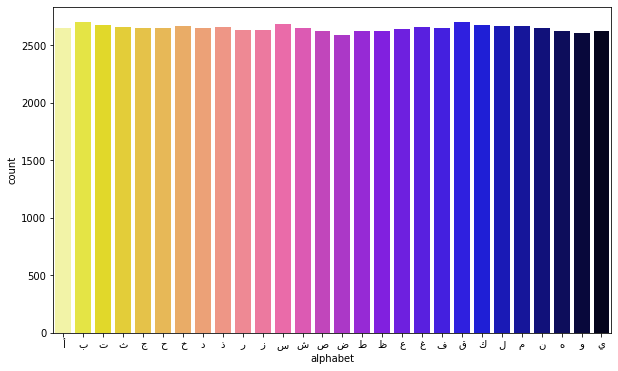

In [63]:
AIA9KTrain_x=pd.read_csv("AIA9KtrainingImagesCleaned.csv",header=None)
AugmentedTrain_x=pd.read_csv("AIA9KtrainingImagesCleanedAugmented.csv",header=None)
AIA9KTrain_y=pd.read_csv("AIA9KtrainingLabelsCleaned.csv",header=None )
AugmentedTrain_y=pd.read_csv("AIA9KtrainingLabelsCleanedAugmented.csv",header=None)



AIA9KTrain_x=np.array(AIA9KTrain_x)
AIA9KTrain_x=AIA9KTrain_x/255
AIA9KTrain_x=pd.DataFrame(AIA9KTrain_x)

AugmentedTrain_x=np.array(AugmentedTrain_x)
AugmentedTrain_x=AugmentedTrain_x/255
AugmentedTrain_x=pd.DataFrame(AugmentedTrain_x)

AIA9KTrain_y=np.array(AIA9KTrain_y)
AIA9KTrain_y=np.array(AIA9KTrain_y)
AIA9KTrain_y=np.array(AIA9KTrain_y)

AugmentedTrain_y=np.array(AugmentedTrain_y)
AugmentedTrain_y=np.array(AugmentedTrain_y)
AugmentedTrain_y=np.array(AugmentedTrain_y)



y_train =np.concatenate((AIA9KTrain_y,AugmentedTrain_y))
framesx = [AIA9KTrain_x, AugmentedTrain_x]
x_train  = pd.concat(framesx)


x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = 1-x_train

# idx = np.random.permutation(len(x_train))
# x_train,y_train = x_train[idx], y_train[idx]




x_train = x_train.reshape([-1, 32, 32, 1])
y=y_train
y_train=y_train.reshape(-1)


y_train=pd.get_dummies(y_train).values

y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}
ccc=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])
y_class = [np.argmax(element) for element in y_train]
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=ccc)
plt.xlabel("alphabet")
plt.show()



In [74]:
x_train.shape, y_train.shape

((74203, 32, 32, 1), (74203, 28))

# Show examples from training images

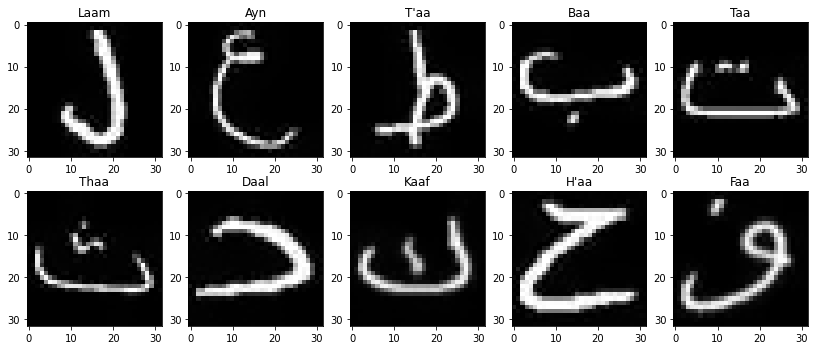

In [64]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_train]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(0, 5000)
    plt.imshow(x_train[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

# Pre-Processing the testing images

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



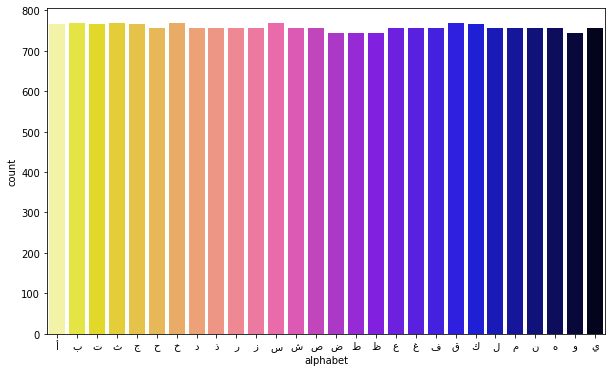

In [65]:
AIA9KTest_x=pd.read_csv("AIA9KtestingImagesCleaned.csv",header=None)
AugmentedTest_x=pd.read_csv("AIA9KtestingImagesCleanedAugmented.csv",header=None)
AIA9KTest_y=pd.read_csv("AIA9KtestingLabelsCleaned.csv",header=None )
AugmentedTest_y=pd.read_csv("AIA9KtestingLabelsCleanedAugmented.csv",header=None)



AIA9KTest_x=np.array(AIA9KTest_x)
AIA9KTest_x=AIA9KTest_x/255
AIA9KTest_x=pd.DataFrame(AIA9KTest_x)

AugmentedTest_x=np.array(AugmentedTest_x)
AugmentedTest_x=AugmentedTest_x/255
AugmentedTest_x=pd.DataFrame(AugmentedTest_x)

AIA9KTest_y=np.array(AIA9KTest_y)
AIA9KTest_y=np.array(AIA9KTest_y)
AIA9KTest_y=np.array(AIA9KTest_y)

AugmentedTest_y=np.array(AugmentedTest_y)
AugmentedTest_y=np.array(AugmentedTest_y)
AugmentedTest_y=np.array(AugmentedTest_y)



y_test =np.concatenate((AIA9KTest_y,AugmentedTest_y))
framesx = [AIA9KTest_x, AugmentedTest_x]
x_test  = pd.concat(framesx)


x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = 1-x_test

# idx = np.random.permutation(len(x_test))
# x_test,y_test = x_test[idx], y_test[idx]




x_test = x_test.reshape([-1, 32, 32, 1])
y=y_test
y_test=y_test.reshape(-1)


y_test=pd.get_dummies(y_test).values
y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}
ccc=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])
y_class = [np.argmax(element) for element in y_test]
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=ccc)
plt.xlabel("alphabet")
plt.show()



#  Show examples from testing images

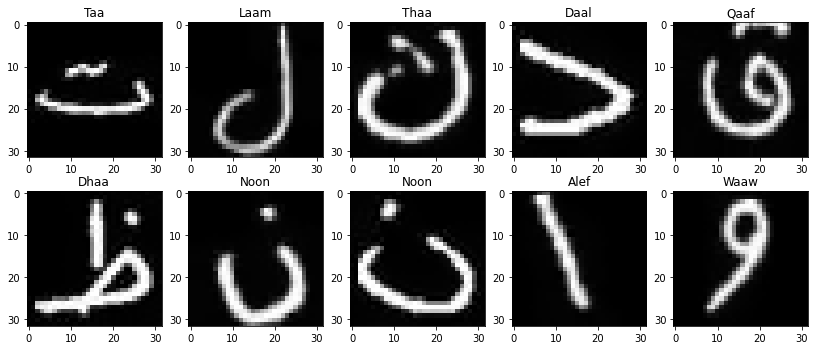

In [66]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_test]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(150, 3000)
    plt.imshow(x_test[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

# Pre-Processing the vaildation images

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



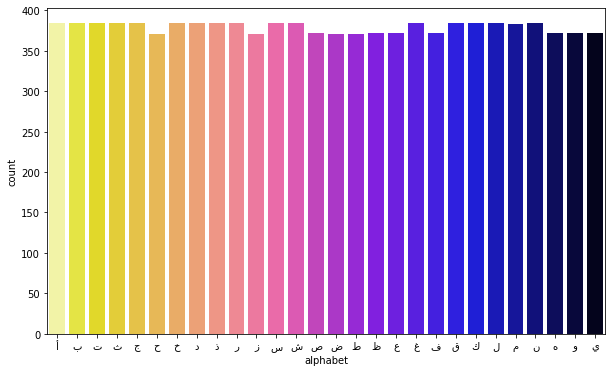

In [95]:
AIA9Kvaildation_x=pd.read_csv("AIA9KvaildationImagesCleaned.csv",header=None)
Augmentedvaildation_x=pd.read_csv("AIA9KvaildationImagesCleanedAugmented.csv",header=None)
AIA9Kvaildation_y=pd.read_csv("AIA9KvaildationLabelsCleaned.csv",header=None )
Augmentedvaildation_y=pd.read_csv("AIA9KvaildationLabelsCleanedAugmented.csv",header=None)



AIA9Kvaildation_x=np.array(AIA9Kvaildation_x)
AIA9Kvaildation_x=AIA9Kvaildation_x/255
AIA9Kvaildation_x=pd.DataFrame(AIA9Kvaildation_x)

Augmentedvaildation_x=np.array(Augmentedvaildation_x)
Augmentedvaildation_x=Augmentedvaildation_x/255
Augmentedvaildation_x=pd.DataFrame(Augmentedvaildation_x)

AIA9Kvaildation_y=np.array(AIA9Kvaildation_y)


Augmentedvaildation_y=np.array(Augmentedvaildation_y)




y_val =np.concatenate((AIA9Kvaildation_y,Augmentedvaildation_y))
framesx = [AIA9Kvaildation_x, Augmentedvaildation_x]
x_val  = pd.concat(framesx)


x_val = np.array(x_val)
y_val = np.array(y_val)

x_val = 1-x_val

# idx = np.random.permutation(len(x_val))
# x_val,y_val = x_val[idx], y_val[idx]




x_val = x_val.reshape([-1, 32, 32, 1])
y=y_val
y_val=y_val.reshape(-1)


y_val=pd.get_dummies(y_val).values
y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}
ccc=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])
y_class = [np.argmax(element) for element in y_val]
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=ccc)
plt.xlabel("alphabet")
plt.show()



In [96]:
x_val.shape, y_val.shape

((10615, 32, 32, 1), (10615, 28))

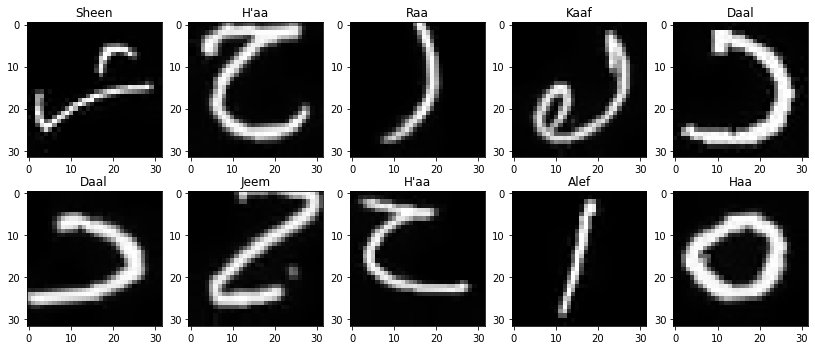

In [97]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_val]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(150, 3000)
    plt.imshow(x_val[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

# CNN approach

In [98]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(32, 32,1)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=30,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 74203 samples, validate on 10615 samples
Epoch 1/30
74203/74203 [==============================] - 12s 167us/step - loss: 0.7286 - accuracy: 0.7736 - val_loss: 0.2217 - val_accuracy: 0.9294
Epoch 2/30
74203/74203 [==============================] - 12s 164us/step - loss: 0.2435 - accuracy: 0.9248 - val_loss: 0.1757 - val_accuracy: 0.9432
Epoch 3/30
74203/74203 [==============================] - 12s 159us/step - loss: 0.1790 - accuracy: 0.9434 - val_loss: 0.1547 - val_accuracy: 0.9537
Epoch 4/30
74203/74203 [==============================] - 12s 166us/step - loss: 0.1496 - accuracy: 0.9524 - val_loss: 0.1578 - val_accuracy: 0.9520
Epoch 5/30
74203/74203 [==============================] - 13s 171us/step - loss: 0.1307 - accuracy: 0.9574 - val_loss: 0.1315 - val_accuracy: 0.9607
Epoch 6/30
74203/74203 [==============================] - 13s 172us/step - loss: 0.1178 - accuracy: 0.9624 - val_loss: 0.1472 - val_accuracy: 0.9569
Epoch 7/30
74203/74203 [==============================] 

[0.1460852224444276, 0.9668205976486206]

# Saving the model & model's history

In [35]:
accuracy=round(accuracy[1],5)*100

save_model= str(accuracy)+"AIA9KAugmented_ourmodel_10"

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5" )

# Loading the model & model's history

In [ ]:
pickle_in= open(save_model,"rb")
history=pickle.load(pickle_in)
model=load_model(save_model+"h.5")

# VGG16 with modifications

In [129]:
model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=2, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=30,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 74203 samples, validate on 10615 samples
Epoch 1/30
74203/74203 [==============================] - 44s 588us/step - loss: 0.3244 - accuracy: 0.8999 - val_loss: 0.2391 - val_accuracy: 0.9289
Epoch 2/30
74203/74203 [==============================] - 40s 538us/step - loss: 0.0744 - accuracy: 0.9761 - val_loss: 0.2565 - val_accuracy: 0.9423
Epoch 3/30
74203/74203 [==============================] - 39s 526us/step - loss: 0.0473 - accuracy: 0.9838 - val_loss: 0.2328 - val_accuracy: 0.9487
Epoch 4/30
74203/74203 [==============================] - 39s 532us/step - loss: 0.0340 - accuracy: 0.9880 - val_loss: 0.2954 - val_accuracy: 0.9421: 0.0341 
Epoch 5/30
74203/74203 [==============================] - 39s 530us/step - loss: 0.0276 - accuracy: 0.9899 - val_loss: 0.2560 - val_accuracy: 0.9495
Epoch 6/30
74203/74203 [==============================] - 39s 530us/step - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.3016 - val_accuracy: 0.9506
Epoch 7/30
74203/74203 [=======================

[0.3707944639030358, 0.9551324248313904]

# LeNet5 model

In [124]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (32, 32, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(28, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

history=model.fit(x_train, y_train,validation_data=(x_val,y_val), callbacks=[model_checkpoint_callback], epochs=50,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy
#99 highest

Train on 74203 samples, validate on 10615 samples
Epoch 1/50
74203/74203 [==============================] - 27s 366us/step - loss: 0.6946 - accuracy: 0.7854 - val_loss: 0.4213 - val_accuracy: 0.8753

Epoch 00001: val_accuracy improved from -inf to 0.87527, saving model to C:\Users\MOneb\deep learning\Final\AIA9KAugmentedModels\best.h5
Epoch 2/50
74203/74203 [==============================] - 26s 355us/step - loss: 0.2284 - accuracy: 0.9261 - val_loss: 0.2311 - val_accuracy: 0.9324

Epoch 00002: val_accuracy improved from 0.87527 to 0.93236, saving model to C:\Users\MOneb\deep learning\Final\AIA9KAugmentedModels\best.h5
Epoch 3/50
74203/74203 [==============================] - 25s 339us/step - loss: 0.1594 - accuracy: 0.9481 - val_loss: 0.1728 - val_accuracy: 0.9456

Epoch 00003: val_accuracy improved from 0.93236 to 0.94564, saving model to C:\Users\MOneb\deep learning\Final\AIA9KAugmentedModels\best.h5
Epoch 4/50
74203/74203 [==============================] - 25s 340us/step - loss: 0.

74203/74203 [==============================] - 25s 342us/step - loss: 0.0203 - accuracy: 0.9929 - val_loss: 0.1868 - val_accuracy: 0.9624

Epoch 00036: val_accuracy did not improve from 0.96458
Epoch 37/50
74203/74203 [==============================] - 25s 340us/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.2123 - val_accuracy: 0.9606

Epoch 00037: val_accuracy did not improve from 0.96458
Epoch 38/50
74203/74203 [==============================] - 25s 339us/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.1947 - val_accuracy: 0.9629

Epoch 00038: val_accuracy did not improve from 0.96458
Epoch 39/50
74203/74203 [==============================] - 25s 342us/step - loss: 0.0188 - accuracy: 0.9935 - val_loss: 0.1939 - val_accuracy: 0.9621

Epoch 00039: val_accuracy did not improve from 0.96458
Epoch 40/50
74203/74203 [==============================] - 25s 340us/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 0.1900 - val_accuracy: 0.9625

Epoch 00040: val_accuracy did not imp

[0.14956177985695351, 0.9736073017120361]

In [125]:
accuracy = str(round(accuracy[1], 5) * 100)

save_model = accuracy + "AIA9KAugmentedBlack_LeNet5_10"

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5" )

In [ ]:
pickle_in= open(save_model,"rb")
history=pickle.load(pickle_in)
model=load_model(save_model+"h5")

# Confusion matrix

<AxesSubplot:>

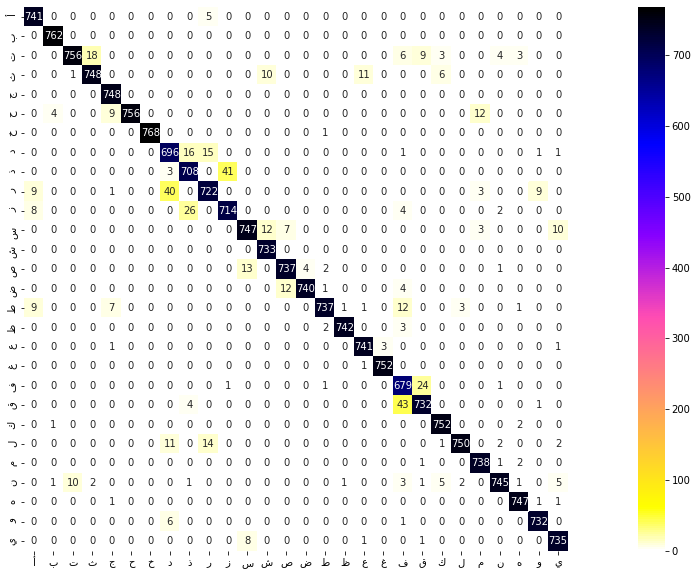

In [126]:
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
a=confusion_matrix(y_classes, y_classes12)
df_cm = pd.DataFrame(a, index = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"],
                  columns = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"])
plt.figure(figsize = (25,10))
sn.heatmap(df_cm, annot=True,cmap="gnuplot2_r",fmt='g', square=True)

# Showing some misclassified images

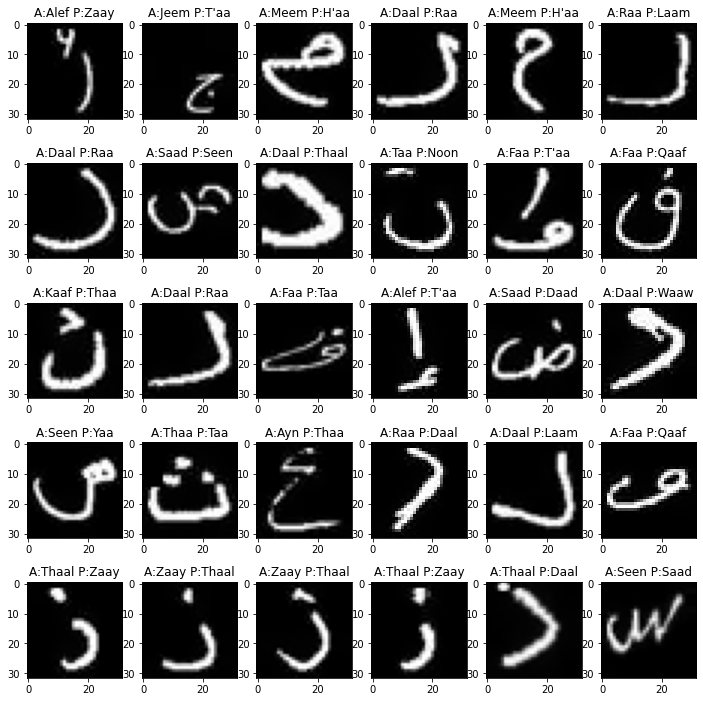

In [127]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
y_acutal=[]
y_miss=[]
ind=[]
img=[]
for i in range(len(y_classes12)):
     if y_classes[i] != y_classes12[i]:
        y_acutal.append(y_classes12[i])
        y_miss.append(y_classes[i])
        img.append(x_test[i])
plt.figure(figsize=(12 ,15))
for i in range(30):
    plt.subplot(6,6,i+1)
    plt.imshow(img[i],"gray")
    plt.title("A:"+arabic_characters[y_acutal[i]]+" P:"+arabic_characters[y_miss[i]])
plt.show()

# inceptionV3

In [136]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes failters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
visible = Input(shape=(32, 32, 1))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
model.save("inc.h5" )
prev_model = load_model("inc.h5")
model=Sequential()
model.add(prev_model)
model.add(Flatten())
model.add(Dense(28, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)


history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor]  ,epochs=50,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 32, 32, 96)   192         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 32, 32, 16)   32          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 32, 32, 1)    0           input_3[0][0]                    
____________________________________________________________________________________________

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



Train on 74203 samples, validate on 10615 samples
Epoch 1/50
74203/74203 [==============================] - 75s 1ms/step - loss: 0.4061 - accuracy: 0.8747 - val_loss: 0.3520 - val_accuracy: 0.8941
Epoch 2/50
74203/74203 [==============================] - 72s 975us/step - loss: 0.1061 - accuracy: 0.9646 - val_loss: 0.3232 - val_accuracy: 0.9128
Epoch 3/50
74203/74203 [==============================] - 72s 966us/step - loss: 0.0537 - accuracy: 0.9819 - val_loss: 0.4188 - val_accuracy: 0.9141
Epoch 4/50
74203/74203 [==============================] - 73s 982us/step - loss: 0.0344 - accuracy: 0.9884 - val_loss: 0.4484 - val_accuracy: 0.9121
Epoch 5/50
74203/74203 [==============================] - 74s 1ms/step - loss: 0.0243 - accuracy: 0.9916 - val_loss: 0.4979 - val_accuracy: 0.9105s - loss: 0.0241 - accuracy
Epoch 6/50
74203/74203 [==============================] - 73s 980us/step - loss: 0.0204 - accuracy: 0.9926 - val_loss: 0.6022 - val_accuracy: 0.9084
Epoch 7/50
74203/74203 [=========

[0.7442301266911172, 0.9189838767051697]

# Residual-Net

In [137]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

# define model input
visible = Input(shape=(32, 32, 1))
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
model.save("Res.h5" )
prev_model = load_model("Res.h5")
model=Sequential()
model.add(prev_model)
model.add(Flatten())
model.add(Dense(28, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)


history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor]  ,epochs=50,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 32, 32, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 32, 32, 64)   128         input_4[0][0]                    
____________________________________________________________________________________________

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



Train on 74203 samples, validate on 10615 samples
Epoch 1/50
74203/74203 [==============================] - 14s 195us/step - loss: 0.4708 - accuracy: 0.8571 - val_loss: 0.4146 - val_accuracy: 0.8728
Epoch 2/50
74203/74203 [==============================] - 15s 197us/step - loss: 0.1519 - accuracy: 0.9501 - val_loss: 0.4107 - val_accuracy: 0.8837
Epoch 3/50
74203/74203 [==============================] - 15s 195us/step - loss: 0.0735 - accuracy: 0.9753 - val_loss: 0.4682 - val_accuracy: 0.8867
Epoch 4/50
74203/74203 [==============================] - 14s 192us/step - loss: 0.0421 - accuracy: 0.9851 - val_loss: 0.5150 - val_accuracy: 0.8906
Epoch 5/50
74203/74203 [==============================] - 14s 192us/step - loss: 0.0309 - accuracy: 0.9889 - val_loss: 0.6023 - val_accuracy: 0.8924
Epoch 6/50
74203/74203 [==============================] - 14s 190us/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.7006 - val_accuracy: 0.8854
Epoch 7/50
74203/74203 [==============================] 

[1.2153539027220983, 0.8875483274459839]